In [14]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy import stats
from tqdm import tqdm

In [2]:
mu = 5
sigma = 2

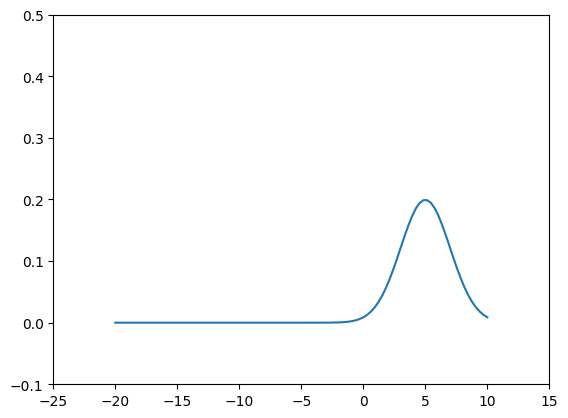

In [3]:
l = np.linspace(-20, 10, 100)
plt.plot(l, norm.pdf(l, mu, sigma))
plt.xlim(-25,15)
plt.ylim(-0.1,0.5)
plt.show()

# Get samples from gaussian distribution

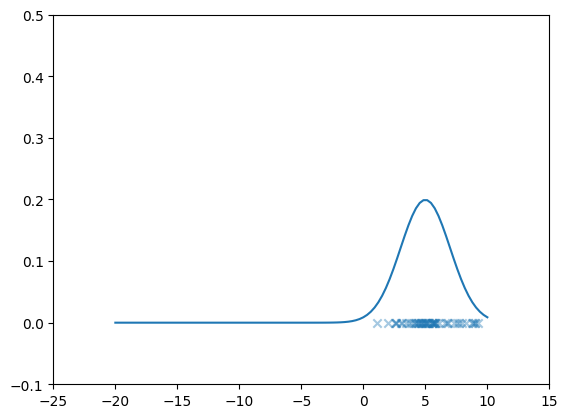

In [4]:
num_samples = 50
# l = np.linspace(-20, 10, 100)
plt.plot(l, norm.pdf(l, mu, sigma))

samples = norm.rvs(mu, sigma, size=num_samples)
plt.scatter(samples,[0 for _ in range(num_samples)], marker='x', alpha=0.4)

plt.xlim(-25,15)
plt.ylim(-0.1,0.5)
plt.show()

# Resression from the observed data

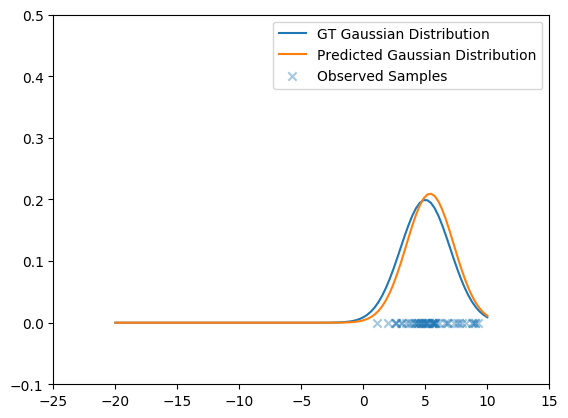

In [5]:


# plot GT distribution
# l = np.linspace(-20, 10, 100)
plt.plot(l, norm.pdf(l, mu, sigma), label='GT Gaussian Distribution')

# plot samples
# num_samples = 20
# samples = norm.rvs(mu, sigma, size=num_samples)
plt.scatter(samples,[0 for _ in range(num_samples)], marker='x', alpha=0.4, label='Observed Samples')

# plot pred distribution
mu_hat, sigma_hat = norm.fit(samples)
plt.plot(l, norm.pdf(l, mu_hat, sigma_hat), label='Predicted Gaussian Distribution')

plt.xlim(-25,15)
plt.ylim(-0.1,0.5)
plt.legend()
plt.show()

# Calculate VaR, CVaR for GT distribution

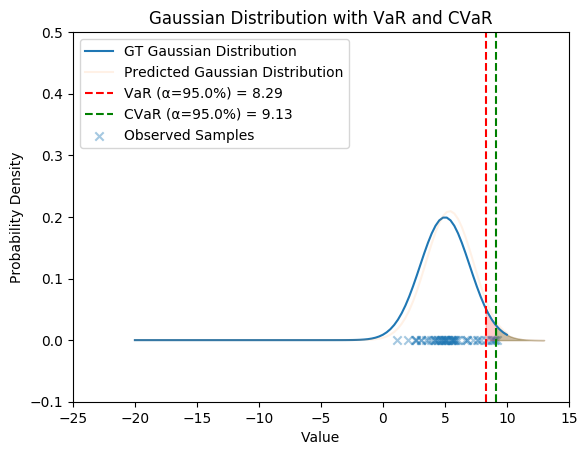

In [8]:


# plot GT distribution
# l = np.linspace(-20, 10, 100)
plt.plot(l, norm.pdf(l, mu, sigma), label='GT Gaussian Distribution')

# plot samples
# num_samples = 20
# samples = norm.rvs(mu, sigma, size=num_samples)
plt.scatter(samples,[0 for _ in range(num_samples)], marker='x', alpha=0.4, label='Observed Samples')

# plot pred distribution
# mu_hat, sigma_hat = norm.fit(samples)
plt.plot(l, norm.pdf(l, mu_hat, sigma_hat), alpha=0.1, label='Predicted Gaussian Distribution')


# Parameters
alpha = 0.95  # confidence level

# VaR calculation
z_alpha = stats.norm.ppf(alpha)
VaR = mu + sigma * z_alpha

# CVaR calculation
pdf_z_alpha = stats.norm.pdf(z_alpha)
CVaR = mu + (sigma * pdf_z_alpha) / (1 - alpha)

# Plotting
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = stats.norm.pdf(x, mu, sigma)

plt.axvline(x=VaR, color='r', linestyle='--', label=f'VaR (α={alpha*100}%) = {VaR:.2f}')
plt.axvline(x=CVaR, color='g', linestyle='--', label=f'CVaR (α={alpha*100}%) = {CVaR:.2f}')
plt.fill_between(x, 0, y, where=(x >= VaR), color='r', alpha=0.2)
plt.fill_between(x, 0, y, where=(x >= CVaR), color='g', alpha=0.2)
plt.title('Gaussian Distribution with VaR and CVaR')
plt.xlabel('Value')
plt.ylabel('Probability Density')

plt.xlim(-25,15)
plt.ylim(-0.1,0.5)
plt.legend()
plt.show()

# Calculate VaR, CVaR for pred distribution

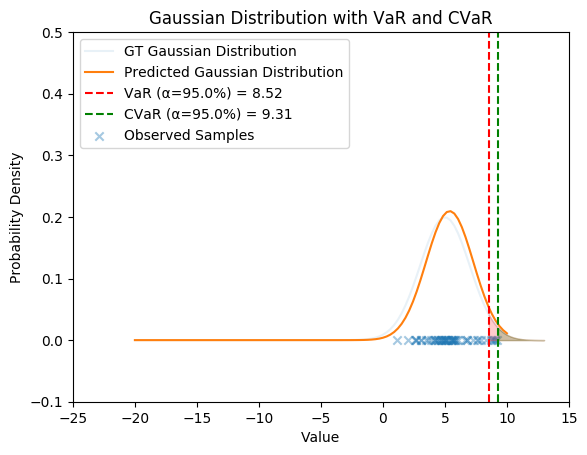

In [9]:


# plot GT distribution
# l = np.linspace(-20, 10, 100)
plt.plot(l, norm.pdf(l, mu, sigma), label='GT Gaussian Distribution', alpha=0.1)

# plot samples
# num_samples = 20
# samples = norm.rvs(mu, sigma, size=num_samples)
plt.scatter(samples,[0 for _ in range(num_samples)], marker='x', alpha=0.4, label='Observed Samples')

# plot pred distribution
# mu_hat, sigma_hat = norm.fit(samples)
# l = np.linspace(-20, 10, 100)
plt.plot(l, norm.pdf(l, mu_hat, sigma_hat), label='Predicted Gaussian Distribution')


# Parameters
alpha = 0.95  # confidence level

# VaR calculation
z_alpha = stats.norm.ppf(alpha)
VaR = mu_hat + sigma_hat * z_alpha

# CVaR calculation
pdf_z_alpha = stats.norm.pdf(z_alpha)
CVaR = mu_hat + (sigma_hat * pdf_z_alpha) / (1 - alpha)

# Plotting
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = stats.norm.pdf(x, mu, sigma)

plt.axvline(x=VaR, color='r', linestyle='--', label=f'VaR (α={alpha*100}%) = {VaR:.2f}')
plt.axvline(x=CVaR, color='g', linestyle='--', label=f'CVaR (α={alpha*100}%) = {CVaR:.2f}')
plt.fill_between(x, 0, y, where=(x >= VaR), color='r', alpha=0.2)
plt.fill_between(x, 0, y, where=(x >= CVaR), color='g', alpha=0.2)
plt.title('Gaussian Distribution with VaR and CVaR')
plt.xlabel('Value')
plt.ylabel('Probability Density')

plt.xlim(-25,15)
plt.ylim(-0.1,0.5)
plt.legend()
plt.show()

# Evidential Deep Regression

## Define model, loss

In [10]:
import torch
from torch import nn
from edl_pytorch import NormalInvGamma, evidential_regression

model = nn.Sequential(
    nn.Linear(1, 16),  # one input dim
    nn.ReLU(),
    NormalInvGamma(16, 1),  # one target variable
)

x = torch.randn(1, 1)  # (batch, dim)
y = torch.randn(1, 1)

pred_nig = model(x)  # (mu, v, alpha, beta)

loss = evidential_regression(
    pred_nig,      # predicted Normal Inverse Gamma parameters
    y,             # target labels
    lamb=0.001,    # regularization coefficient 
)

## Define Train / Test Data

In [12]:
# re-create toy y = x ** 3 + eps example from https://arxiv.org/abs/1910.02600
torch.manual_seed(0)


x_train = torch.concat([
    torch.linspace(-4.9, -5.1, 334).unsqueeze(-1),
    # torch.linspace(-2, -1.7, 250).unsqueeze(-1),
    torch.linspace(1, 1.2, 333).unsqueeze(-1),
    torch.linspace(6.9, 7.1, 333).unsqueeze(-1),
])
# x_train = torch.tensor([-1., 3.]).unsqueeze(-1)
sigma = torch.normal(torch.zeros_like(x_train), 0.1 * torch.ones_like(x_train))
y_train = x_train + sigma
# mu, sigma = 3, 2
# num_samples = 100
# x_train = torch.tensor([3.]*num_samples).unsqueeze(-1)
# y_train = torch.tensor(norm.rvs(mu, sigma, num_samples), dtype=float).unsqueeze(-1)

x_test = torch.linspace(-20, 20, 1000).unsqueeze(-1)
y_test = x_test

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.03it/s]


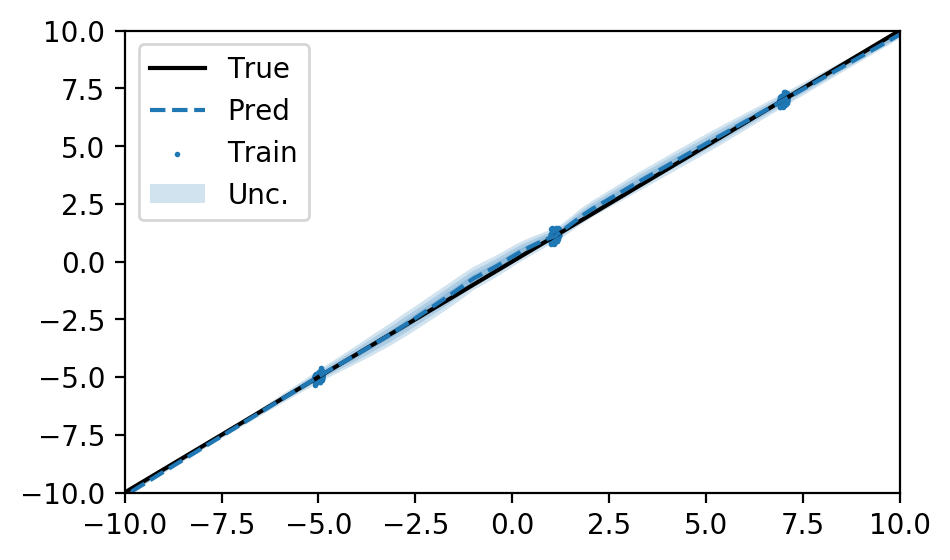

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from edl_pytorch import NormalInvGamma, evidential_regression



model = nn.Sequential(
    nn.Linear(1, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for _ in tqdm(range(10000)):
    for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
        pred = model(x)
        loss = evidential_regression(pred, y, lamb=1e-2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

with torch.no_grad():
    pred = model(x_test)

mu, v, alpha, beta = (d.squeeze() for d in pred)
x_test = x_test.squeeze()
var = torch.sqrt(beta / (v * (alpha - 1)))

# plot code modified from
# https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
plt.figure(figsize=(5, 3), dpi=200)
plt.scatter(x_train, y_train, s=1.0, c="tab:blue", label="Train")
plt.plot(x_test, y_test, c="k", label="True")
plt.plot(x_test, mu, c="tab:blue", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        x_test,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-10, 10)
# plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-10, 10)
plt.legend(loc="upper left")
plt.show()

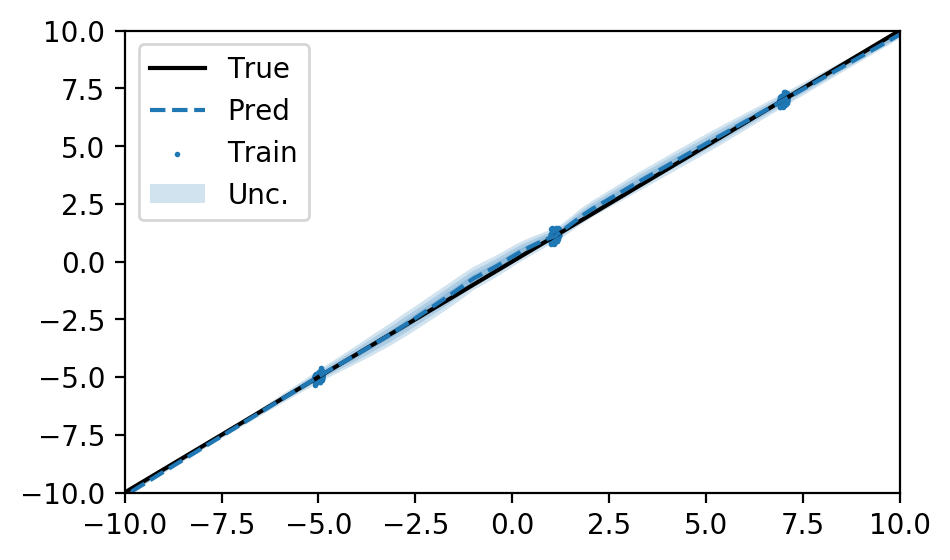

In [17]:
with torch.no_grad():
    pred = model(x_test.unsqueeze(1))

mu, v, alpha, beta = (d.squeeze() for d in pred)

plt.figure(figsize=(5, 3), dpi=200)
plt.scatter(x_train, y_train, s=1.0, c="tab:blue", label="Train")
plt.plot(x_test, y_test, c="k", label="True")
plt.plot(x_test, mu, c="tab:blue", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        x_test,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-10, 10)
# plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-10, 10)
plt.legend(loc="upper left")
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

# Plot mu-sigma at d=-1 and d=3

[-2.9940448] [0.04781744] [5.279152] [0.00218366]


/tmp/ipykernel_2666982/3821297554.py:24: RuntimeWarning: divide by zero encountered in power
  pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
/tmp/ipykernel_2666982/3821297554.py:24: RuntimeWarning: divide by zero encountered in true_divide
  pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
/tmp/ipykernel_2666982/3821297554.py:24: RuntimeWarning: invalid value encountered in multiply
  pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \


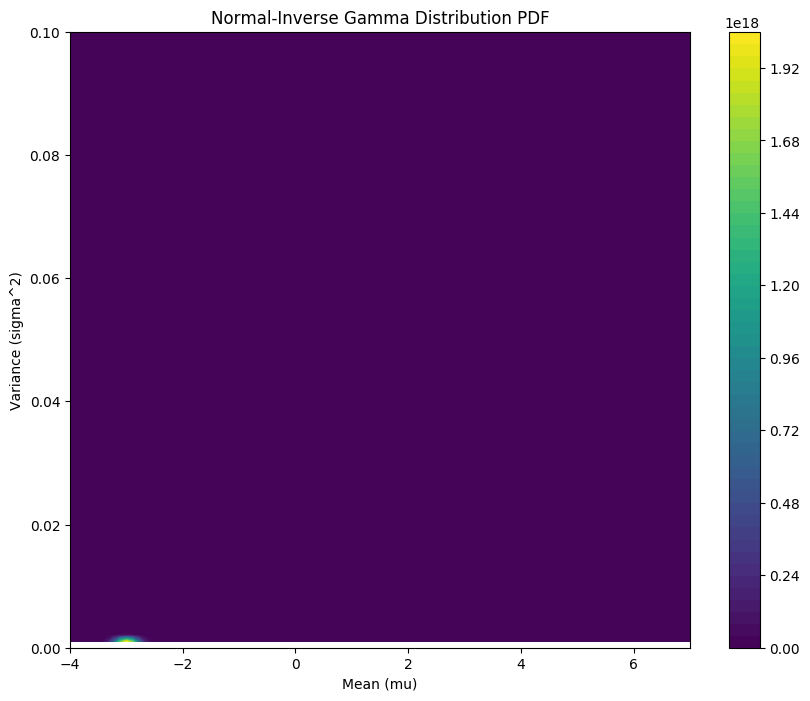

[-1.151356] [0.26724386] [3.001569] [0.05722879]


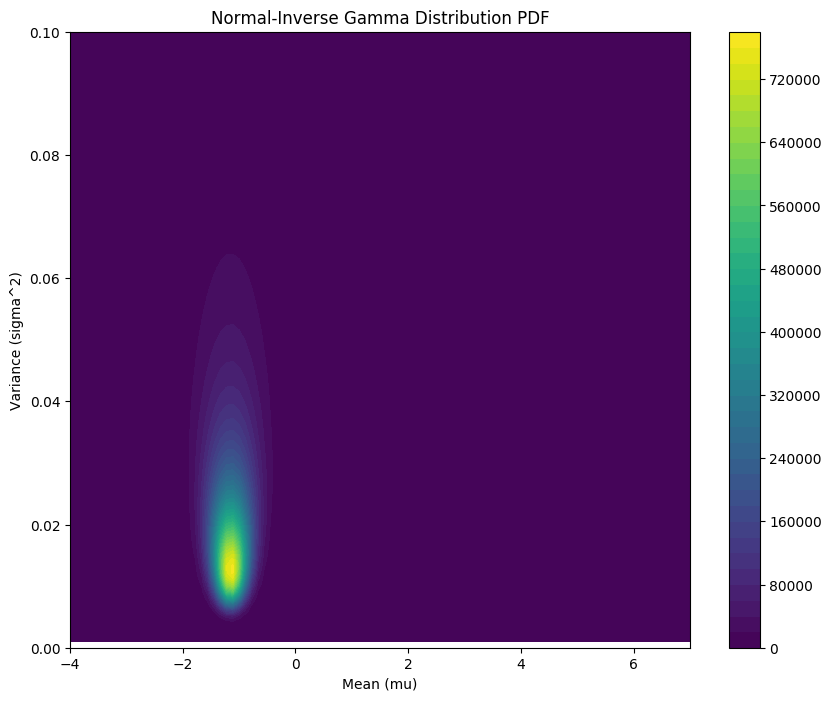

[1.1174495] [0.374074] [2.643102] [0.12647098]


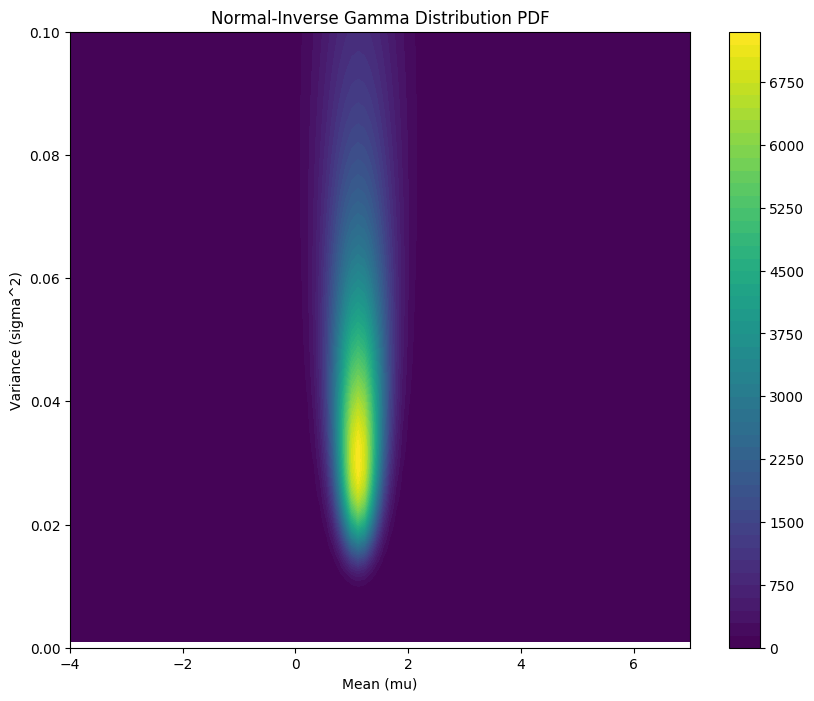

[3.0572953] [0.12840514] [3.9466772] [0.01647336]


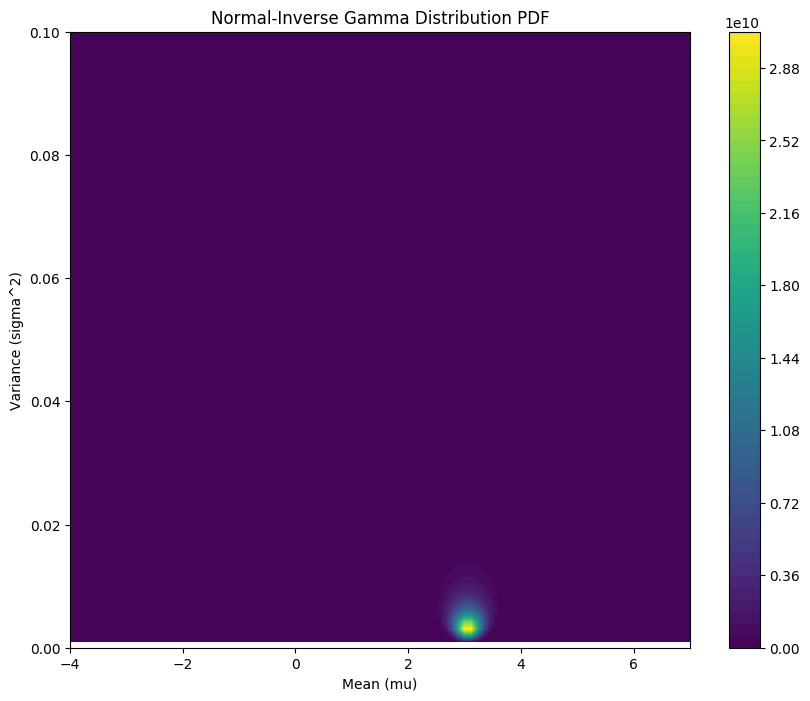

[5.011456] [0.03707089] [5.497464] [0.00185288]


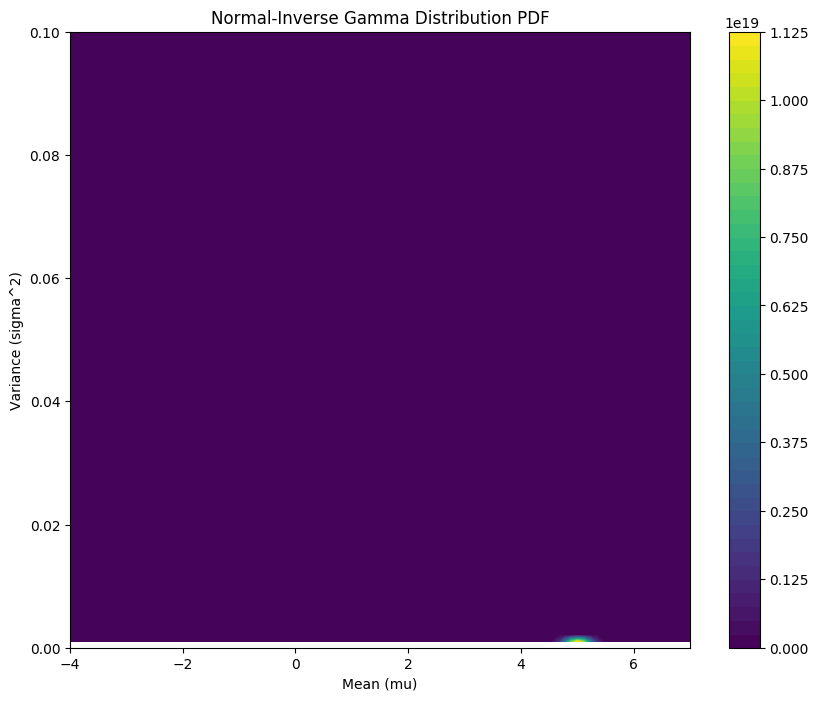

In [671]:
data = [-3., -1., 1., 3., 5.]
for d in data:
    mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor([d]))]
    print(mu_0, lambda_, alpha, beta)
    # Define parameters for the Normal-Inverse Gamma distribution
    # mu_0 = 0  # Prior mean
    # lambda_ = 1  # Scale parameter
    # alpha = 2  # Shape parameter
    # beta = 2  # Scale parameter
    
    # Create a grid for mean (mu) and variance (sigma^2)
    mu = np.linspace(-4, 7, 100)
    sigma2 = np.linspace(0., 0.1, 100)
    mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)
    
    # Compute the probability density function values for the Normal-Inverse Gamma distribution
    pdf_values = np.zeros_like(mu_grid)
    
    for i in range(mu_grid.shape[0]):
        for j in range(mu_grid.shape[1]):
            mu_val = mu_grid[i, j]
            sigma2_val = sigma2_grid[i, j]
            # Normal-Inverse Gamma PDF (up to proportionality constant)
            pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
                               norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
    
    # Plot the PDF values
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(mu, sigma2, pdf_values, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('Mean (mu)')
    plt.ylabel('Variance (sigma^2)')
    plt.title('Normal-Inverse Gamma Distribution PDF')
    plt.show()

[5.011456] [0.03707089] [5.497464] [0.00185288]
E[mu]:  [5.011456]
Var[mu]:  [0.01111339]
E[sigma]:  [0.00041198]
E[sigma] / lambda:  [0.01111339]
diff min:  18.614538891447324
[2.0428963] [27.84275]
msv:  2.3636348

[1.1174495] [0.374074] [2.643102] [0.12647098]
E[mu]:  [1.1174495]
Var[mu]:  [0.20576374]
E[sigma]:  [0.07697087]
E[sigma] / lambda:  [0.20576374]
diff min:  11.295972486791314
[0.5821152] [20.156902]
msv:  1.3603464



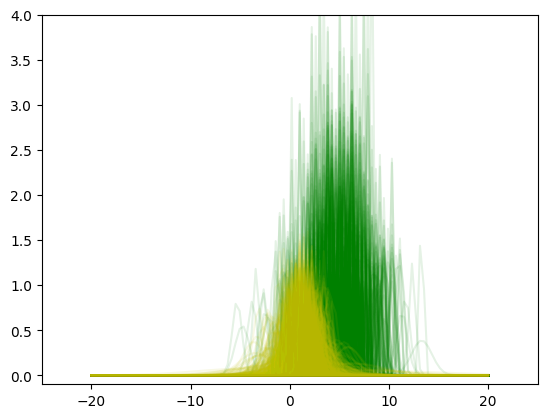

In [801]:
dist_colors = ['g', 'y']
for i,d in enumerate([5., 1.]):
    mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor([d]))]
    print(mu_0, lambda_, alpha, beta)
    print("E[mu]: ",mu_0)
    print("Var[mu]: ",(beta / ((alpha-1)*lambda_)))
    print("E[sigma]: ",(beta / (alpha-1)))
    print("E[sigma] / lambda: ",(beta / (alpha-1)) / lambda_)
    
    num_dist_samples = 1000
    l = np.linspace(-20, 20, 100)
    mu_list = list()
    sigma_list = list()
    msv_list = list()
    for _ in range(num_dist_samples):
        sigma2_sample = invgamma.rvs(alpha, beta)
        mu_sample = norm.rvs(mu_0, np.sqrt(sigma2_sample / lambda_))
        msv_list.append(np.sqrt(sigma2_sample / lambda_))
        mu_list.append(mu_sample)
        sigma_list.append(sigma2_sample / lambda_)
        plt.plot(l, norm.pdf(l, mu_sample, sigma2_sample), alpha=0.1, color=dist_colors[i])
    print("diff min: ",max(mu_list) - min(mu_list))
    print(min(sigma_list), max(sigma_list))
    print("msv: ",np.array(msv_list).mean())
    plt.xlim(-25,25)
    plt.ylim(-0.1,4)
    print()
    
plt.show()

[1.1174495] [0.374074] [2.643102] [0.12647098]
E[mu]:  [1.1174495]
Var[mu]:  [0.20576374]
E[sigma]:  [0.07697087]
Var[sigma]:  [0.0092124]
E[sigma] / lambda:  [0.20576374]
Mode[sigma]:  [0.03471519]
diff min:  12.198133336556168
diff sigma:  [36.06736]
msv:  1.5241243
sigma2 mean:  1.1154930430782604

[3.0572953] [0.12840514] [3.9466772] [0.01647336]
E[mu]:  [3.0572953]
Var[mu]:  [0.04353788]
E[sigma]:  [0.00559049]
Var[sigma]:  [1.6054824e-05]
E[sigma] / lambda:  [0.04353788]
Mode[sigma]:  [0.00333019]
diff min:  7.56629304774502
diff sigma:  [10.00577]
msv:  1.635986
sigma2 mean:  0.37111794059676106



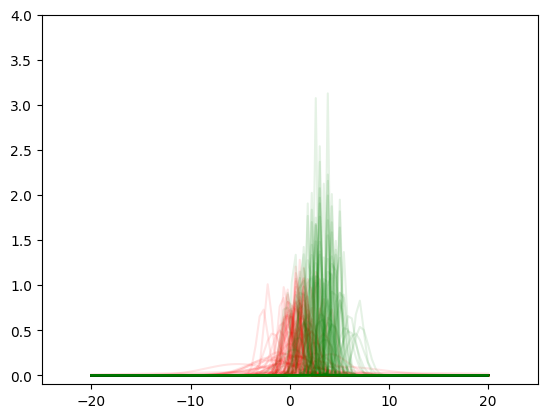

In [808]:
dist_colors = ['r','g']
for i,d in enumerate([1., 3.]):
    mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor([d]))]
    print(mu_0, lambda_, alpha, beta)
    print("E[mu]: ",mu_0)
    print("Var[mu]: ",(beta / ((alpha-1)*lambda_)))
    print("E[sigma]: ",(beta / (alpha-1)))
    print("Var[sigma]: ",(beta**2 / ((alpha-1)**2*(alpha-2))))
    print("E[sigma] / lambda: ",(beta / (alpha-1)) / lambda_)
    print("Mode[sigma]: ",(beta / (alpha+1)))
    
    num_dist_samples = 100
    l = np.linspace(-20, 20, 100)
    mu_list = list()
    sigma_list = list()
    sigma2_list = list()
    msv_list = list()
    for _ in range(num_dist_samples):
        sigma2_sample = invgamma.rvs(alpha, beta)
        sigma2_list.append(sigma2_sample)
        mu_sample = norm.rvs(mu_0, np.sqrt(sigma2_sample / lambda_))
        msv_list.append(np.sqrt(sigma2_sample / lambda_))
        mu_list.append(mu_sample)
        sigma_list.append(sigma2_sample / lambda_)
        plt.plot(l, norm.pdf(l, mu_sample, sigma2_sample), alpha=0.1, color=dist_colors[i])
    print("diff min: ",max(mu_list) - min(mu_list))
    print("diff sigma: ",max(sigma_list) - min(sigma_list))
    print("msv: ",np.array(msv_list).mean())
    print("sigma2 mean: ",np.array(sigma2_list).mean())
    plt.xlim(-25,25)
    plt.ylim(-0.1,4)
    print()
    

plt.show()

TypeError: 'float' object cannot be interpreted as an integer

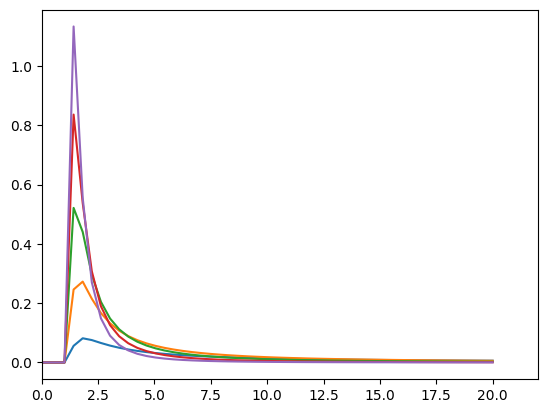

In [821]:
for i in range(1, 10,2):
    plt.plot(l, invgamma.pdf(l,i/5,1))
plt.xlim(0,)
plt.show()

5.4985185454107945
mu:  -1.6666666666666667
mode:  0.7142857142857143


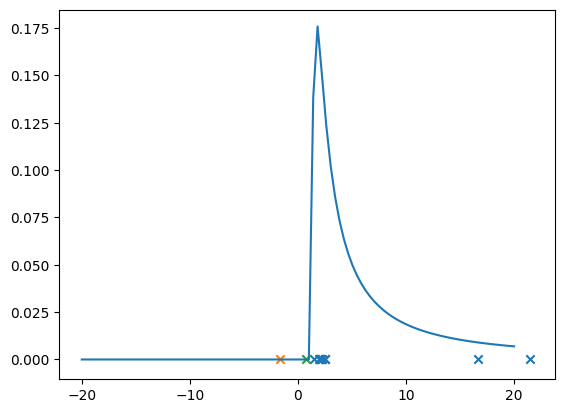

In [805]:

a = 0.4
b = 1
plt.plot(l, invgamma.pdf(l, a,b))

x = invgamma.rvs(1,1, size=10)
plt.scatter(x,[0 for _ in range(10)], marker='x')
print(x.mean())
mu = b/(a-1)
mode = b/(a+1)
print("mu: ",mu)
print("mode: ",mode)
plt.scatter(mu,0, marker='x')
plt.scatter(mode,0, marker='x')
plt.show()

(0, 0.1)

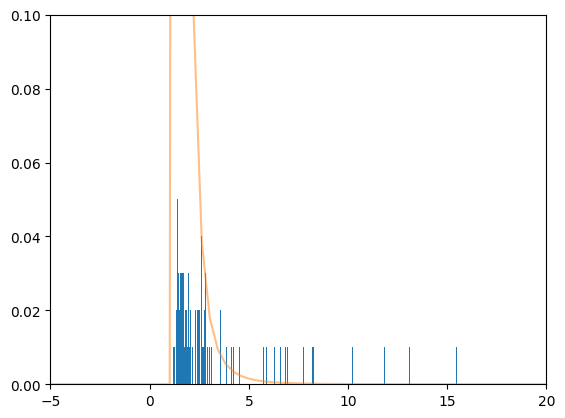

In [799]:
x = invgamma.rvs(1,1, size=100)
plt.hist(x, bins=1000, weights=np.ones(len(x)) / len(x))
plt.plot(l, invgamma.pdf(l, a,b), alpha=0.5)
plt.xlim(-5, 20)
plt.ylim(0,0.1)

[1.1174495] [0.374074] [2.643102] [0.12647098]


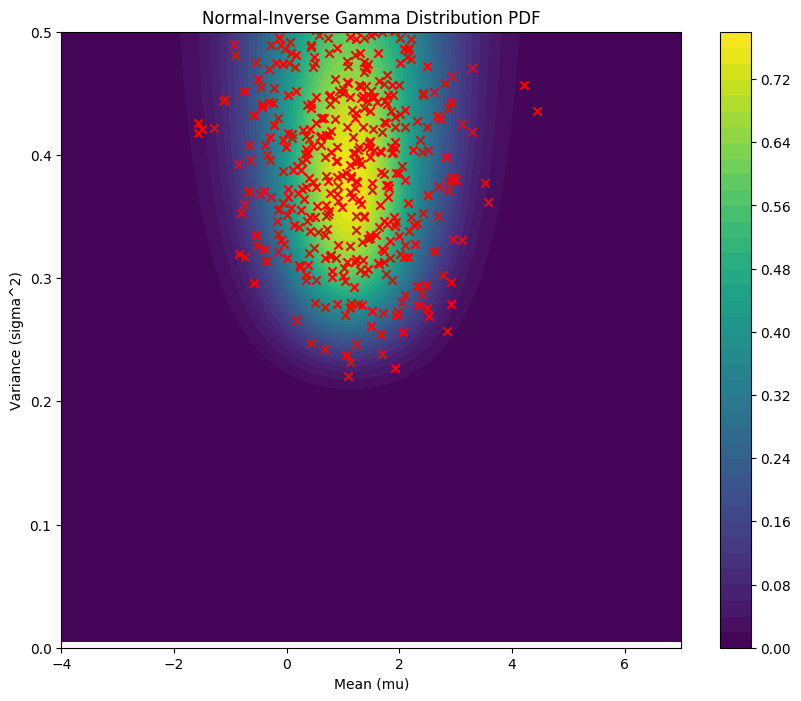

In [838]:
d = 1.
mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor([d]))]
print(mu_0, lambda_, alpha, beta)
# Define parameters for the Normal-Inverse Gamma distribution
# mu_0 = 0  # Prior mean
# lambda_ = 1  # Scale parameter
# alpha = 2  # Shape parameter
# beta = 2  # Scale parameter

# Create a grid for mean (mu) and variance (sigma^2)
mu = np.linspace(-4, 7, 100)
sigma2 = np.linspace(0., 0.5, 100)
mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)

# Compute the probability density function values for the Normal-Inverse Gamma distribution
pdf_values = np.zeros_like(mu_grid)

for i in range(mu_grid.shape[0]):
    for j in range(mu_grid.shape[1]):
        mu_val = mu_grid[i, j]
        sigma2_val = sigma2_grid[i, j]
        # Normal-Inverse Gamma PDF (up to proportionality constant)
        # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
        #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
        pdf_values[i, j] = invgamma.pdf(sigma2_val, alpha, beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

# Plot the PDF values
plt.figure(figsize=(10, 8))


cp = plt.contourf(mu, sigma2, pdf_values, levels=50, cmap='viridis')
plt.colorbar(cp)

num_dist_samples = 1000
l = np.linspace(-20, 20, 100)
mu_list = list()
sigma_list = list()
for _ in range(num_dist_samples):
    sigma2_sample = invgamma.rvs(alpha, beta)
    mu_sample = norm.rvs(mu_0, np.sqrt(sigma2_sample / lambda_))
    mu_list.append(mu_sample)
    sigma_list.append(sigma2_sample)
plt.scatter(mu_list, sigma_list, marker='x', color='r')


plt.xlabel('Mean (mu)')
plt.ylabel('Variance (sigma^2)')
plt.title('Normal-Inverse Gamma Distribution PDF')

plt.xlim(-4,7)
plt.ylim(0,0.5)
plt.show()

[-9.106006] [0.03122871] [11.321062] [0.0001629]
E[mu]:  [-9.106006]
Var[mu]:  [0.00050542]
E[sigma2]:  [1.5783631e-05]
Var[sigma2]:  [2.672689e-11]


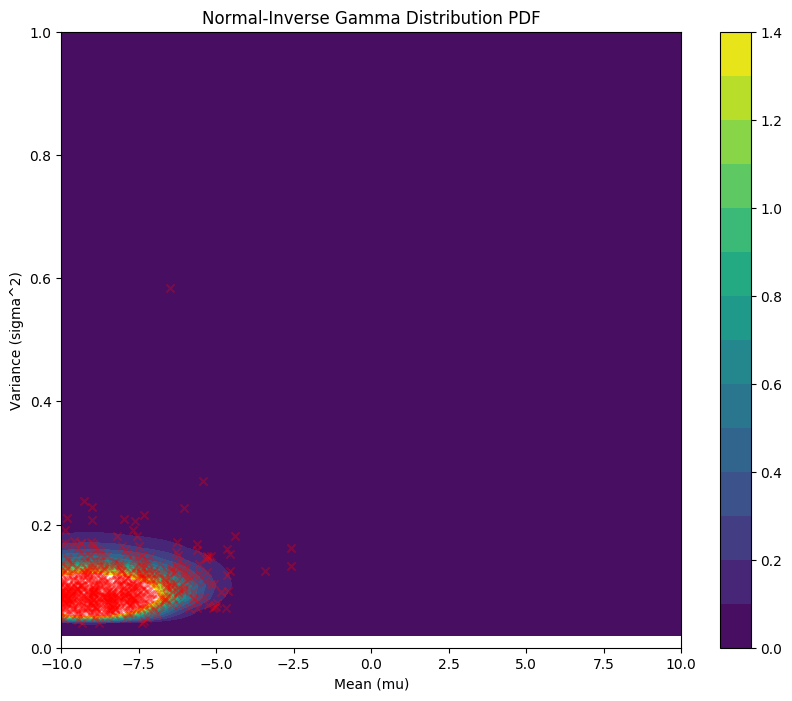

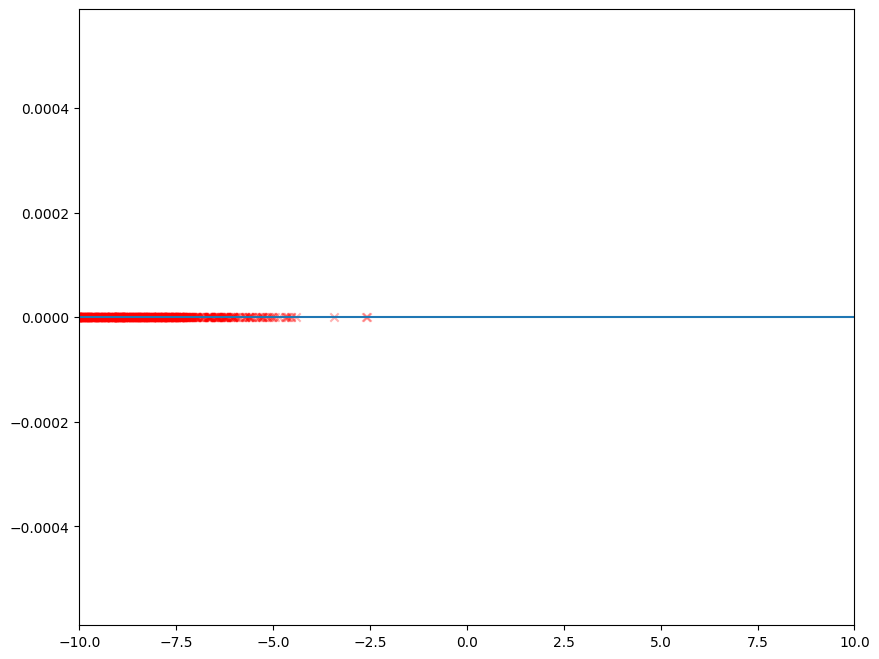

[-4.9802823] [0.1393888] [6.731631] [0.0066674]
E[mu]:  [-4.9802823]
Var[mu]:  [0.00834546]
E[sigma2]:  [0.00116326]
Var[sigma2]:  [2.8598635e-07]


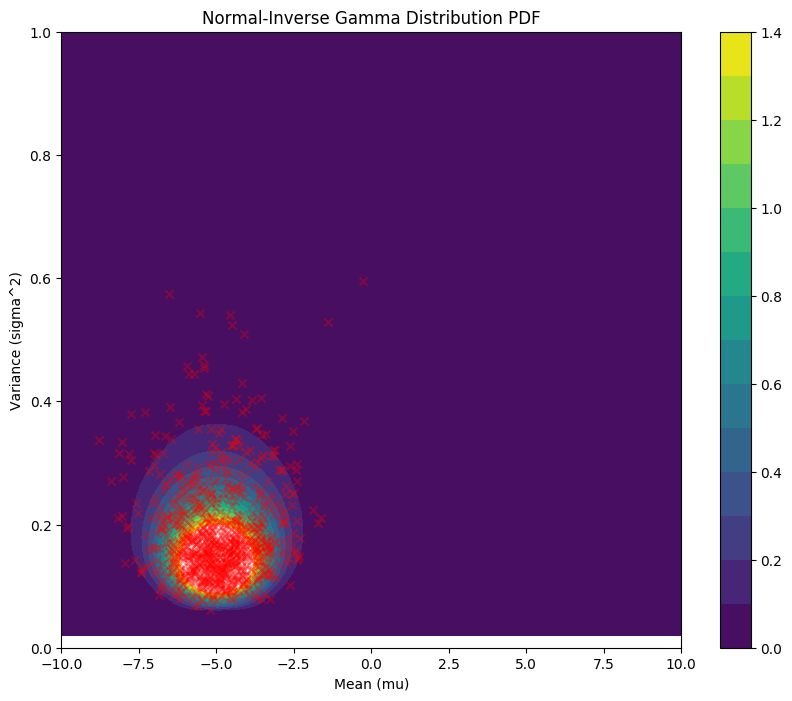

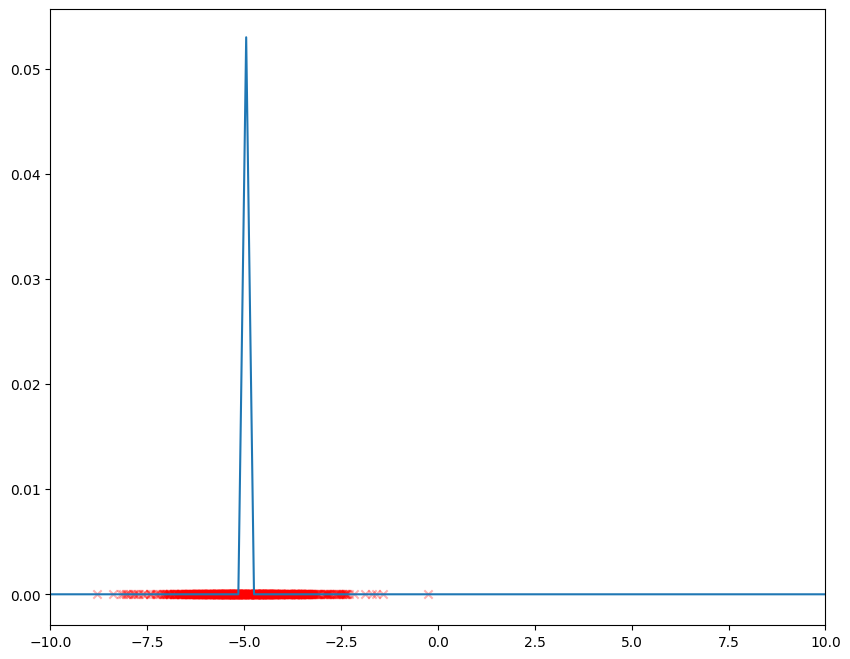

[-1.8955805] [0.2789796] [4.4244127] [0.0302807]
E[mu]:  [-1.8955805]
Var[mu]:  [0.03169622]
E[sigma2]:  [0.0088426]
Var[sigma2]:  [3.2251737e-05]


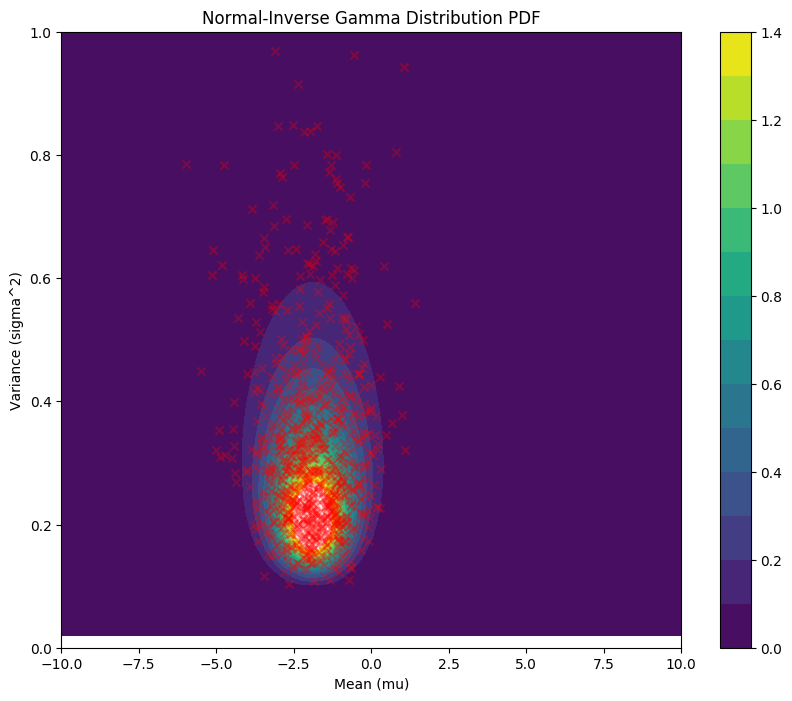

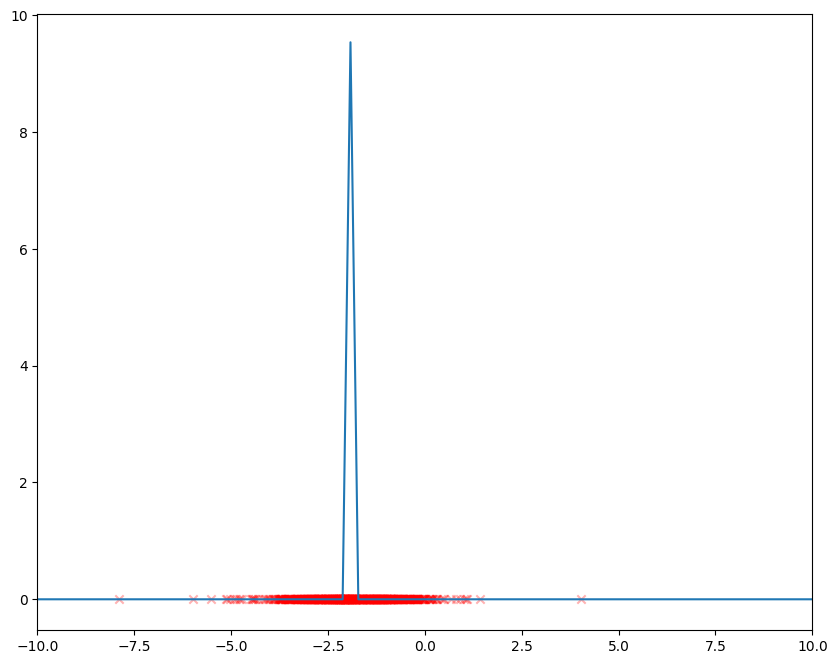

[1.0376964] [0.23969609] [4.4297333] [0.00913443]
E[mu]:  [1.0376964]
Var[mu]:  [0.01111118]
E[sigma2]:  [0.00266331]
Var[sigma2]:  [2.919332e-06]


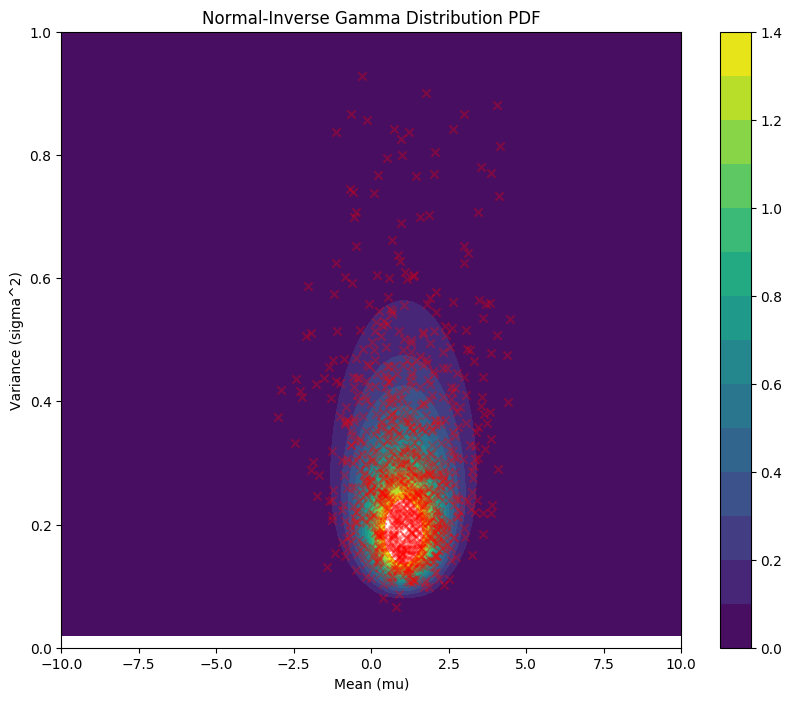

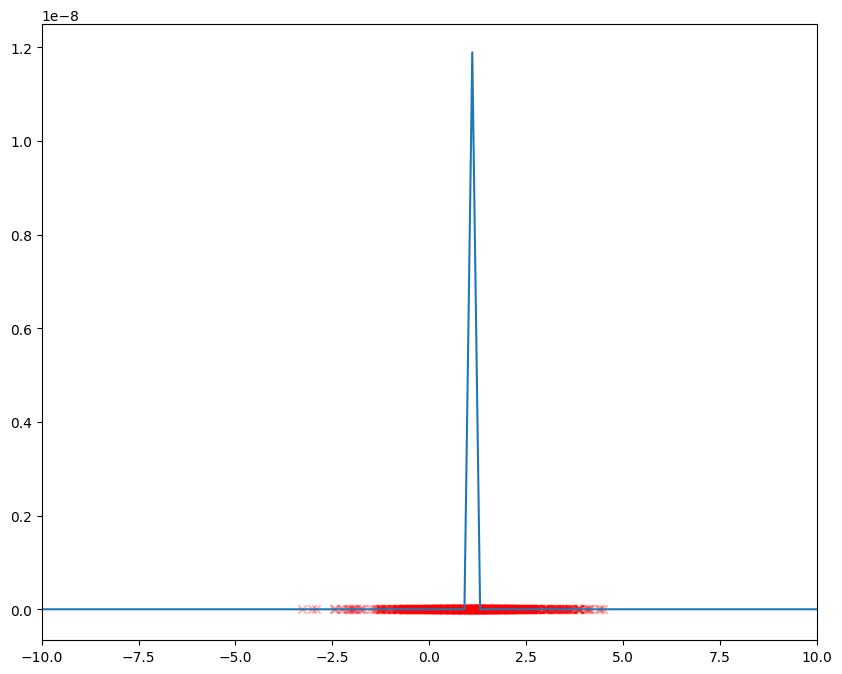

[4.151438] [0.14229538] [4.993032] [0.01088283]
E[mu]:  [4.151438]
Var[mu]:  [0.01915351]
E[sigma2]:  [0.00272546]
Var[sigma2]:  [2.481801e-06]


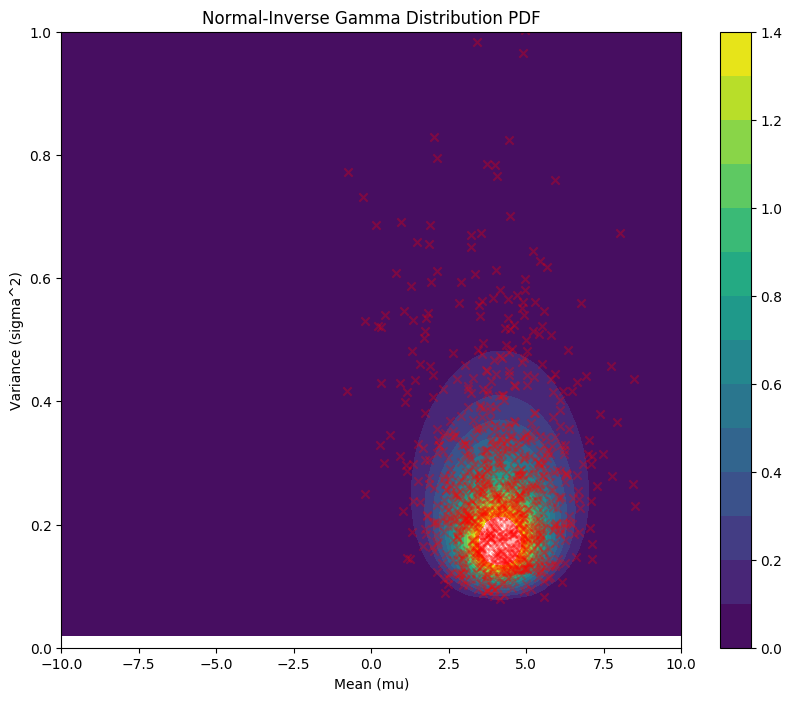

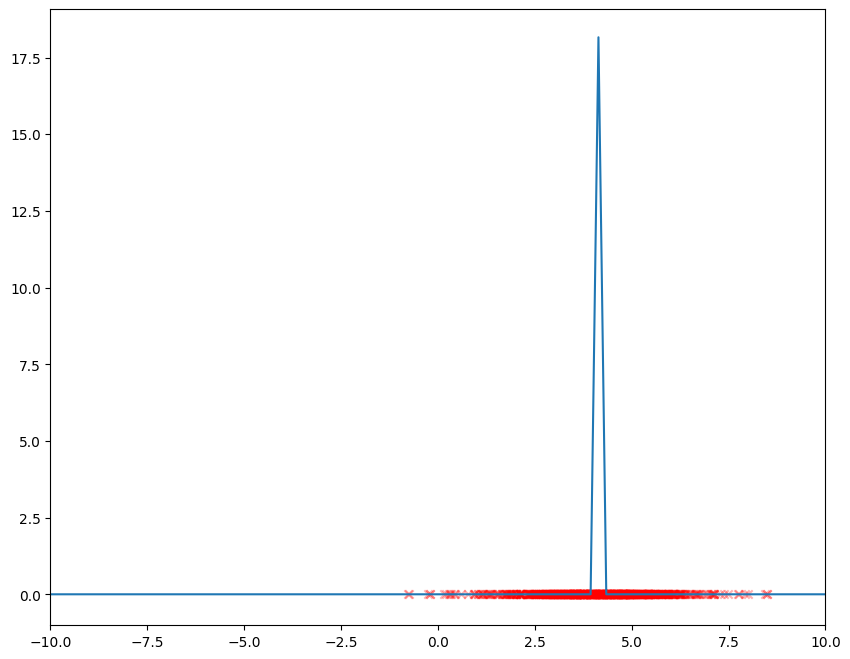

[6.98615] [0.06619448] [6.4814467] [0.0036611]
E[mu]:  [6.98615]
Var[mu]:  [0.01009007]
E[sigma2]:  [0.00066791]
Var[sigma2]:  [9.954368e-08]


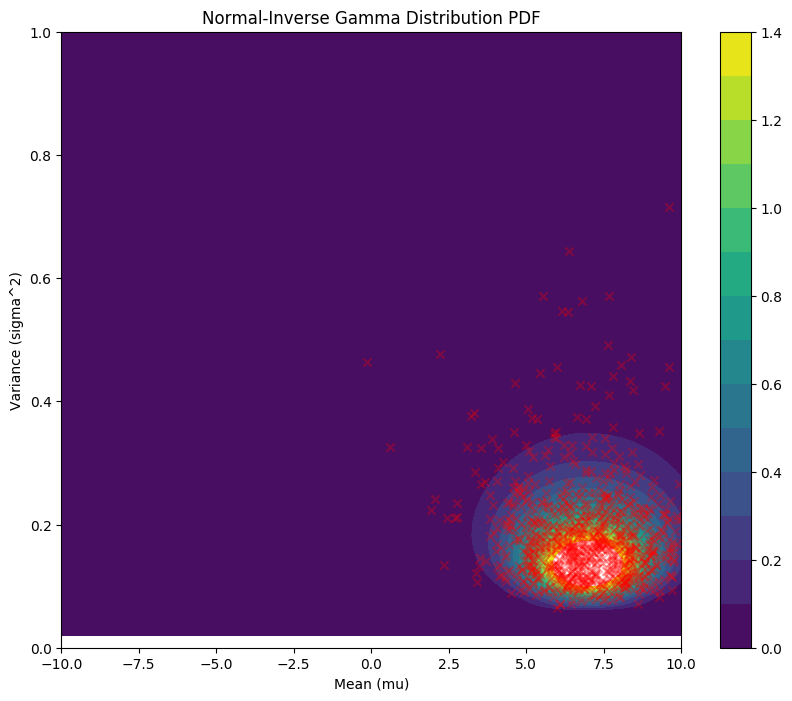

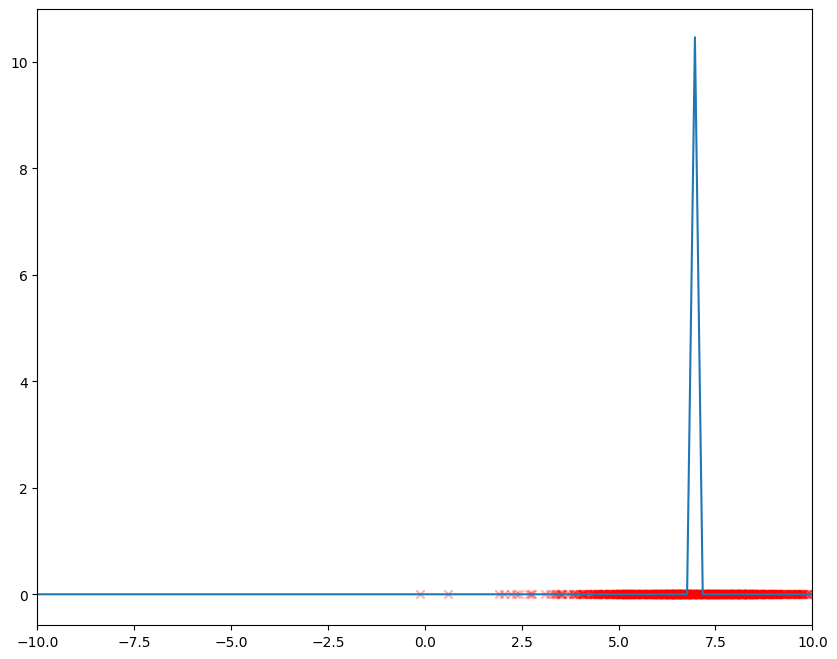

[8.878642] [0.03177121] [7.747474] [0.00107492]
E[mu]:  [8.878642]
Var[mu]:  [0.00501419]
E[sigma2]:  [0.00015931]
Var[sigma2]:  [4.415616e-09]


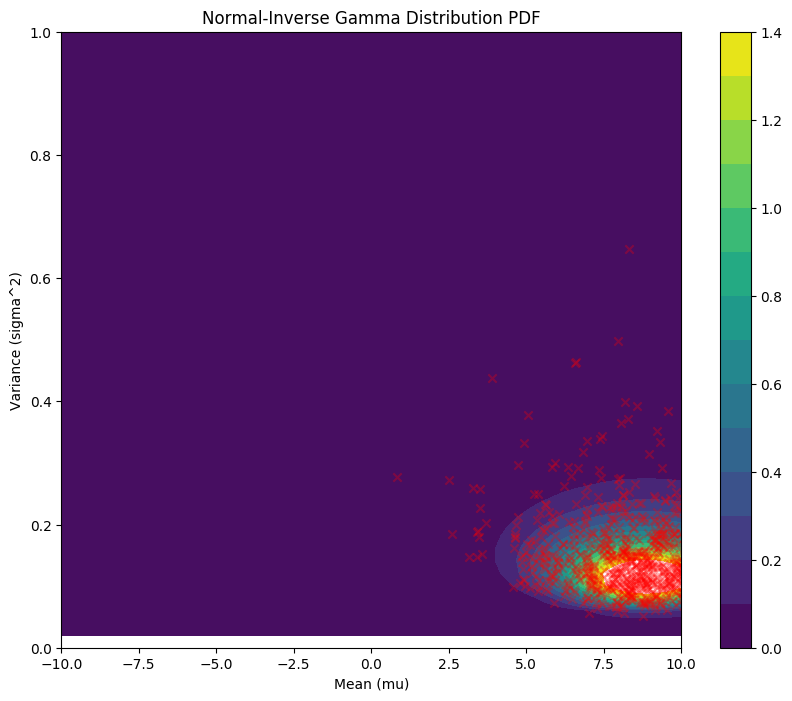

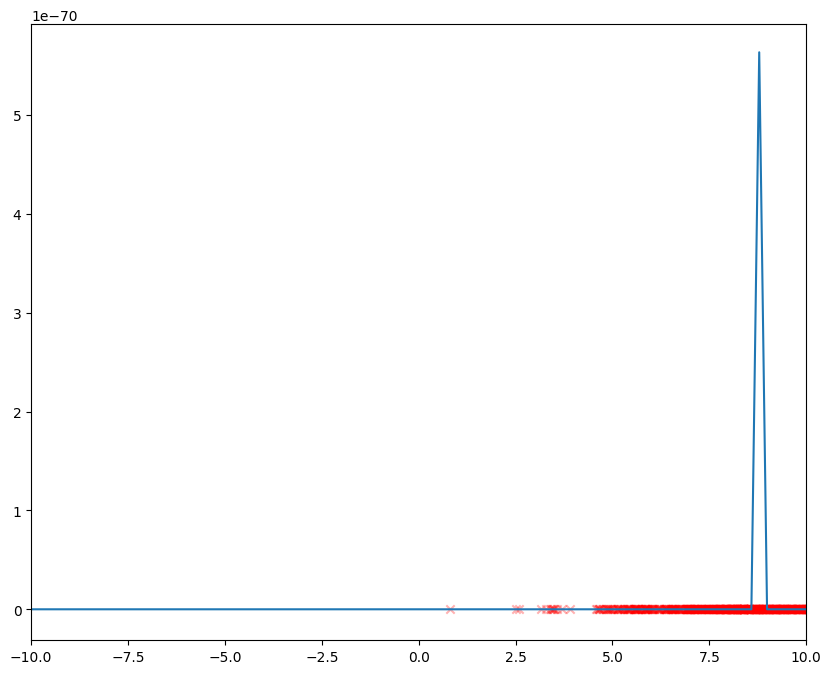

In [22]:
data = [float(x) for x in [-9, -5, -2, 1, 4, 7, 9]]
for d in data:
    mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor([d]))]
    print(mu_0, lambda_, alpha, beta)
    print("E[mu]: ",mu_0)
    print("Var[mu]: ",beta / ((alpha-1) * lambda_))
    print("E[sigma2]: ",beta / (alpha-1))
    print("Var[sigma2]: ",beta**2 / ((alpha-1)**2*(alpha-2)))
    # Define parameters for the Normal-Inverse Gamma distribution
    # mu_0 = 0  # Prior mean
    # lambda_ = 1  # Scale parameter
    # alpha = 2  # Shape parameter
    # beta = 2  # Scale parameter
    
    # Create a grid for mean (mu) and variance (sigma^2)
    mu = np.linspace(-10,10, 100)
    sigma2 = np.linspace(0., 2, 100)
    mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)
    
    # Compute the probability density function values for the Normal-Inverse Gamma distribution
    pdf_values = np.zeros_like(mu_grid)
    
    for i in range(mu_grid.shape[0]):
        for j in range(mu_grid.shape[1]):
            mu_val = mu_grid[i, j]
            sigma2_val = sigma2_grid[i, j]
            # Normal-Inverse Gamma PDF (up to proportionality constant)
            # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
            #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
            pdf_values[i, j] = invgamma.pdf(sigma2_val, alpha, beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

    
    # Plot the PDF values
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(mu, sigma2, pdf_values, levels=[x/10 for x in range(15)], cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('Mean (mu)')
    plt.ylabel('Variance (sigma^2)')
    plt.title('Normal-Inverse Gamma Distribution PDF')

    num_dist_samples = 1000
    l = np.linspace(-20, 20, 100)
    mu_list = list()
    sigma_list = list()
    for _ in range(num_dist_samples):
        sigma2_sample = invgamma.rvs(alpha, beta)
        mu_sample = norm.rvs(mu_0, np.sqrt(sigma2_sample / lambda_))
        mu_list.append(mu_sample)
        sigma_list.append(sigma2_sample)
    plt.scatter(mu_list, sigma_list, marker='x', color='r', alpha=0.3)
    
    plt.xlim(-10,10)
    plt.ylim(0,1)
    plt.show()

    plt.figure(figsize=(10, 8))

    li = np.linspace(-10,10, 100)
    plt.plot(li, norm.pdf(li, mu_0, beta / ((alpha-1) * lambda_)))
    plt.scatter(mu_list, [0 for _ in range(len(mu_list))], marker='x', color='r', alpha=0.3)
    plt.xlim(-10,10)
    plt.show()

Text(0.5, 1.0, 'Normal-Inverse Gamma Distribution PDF')

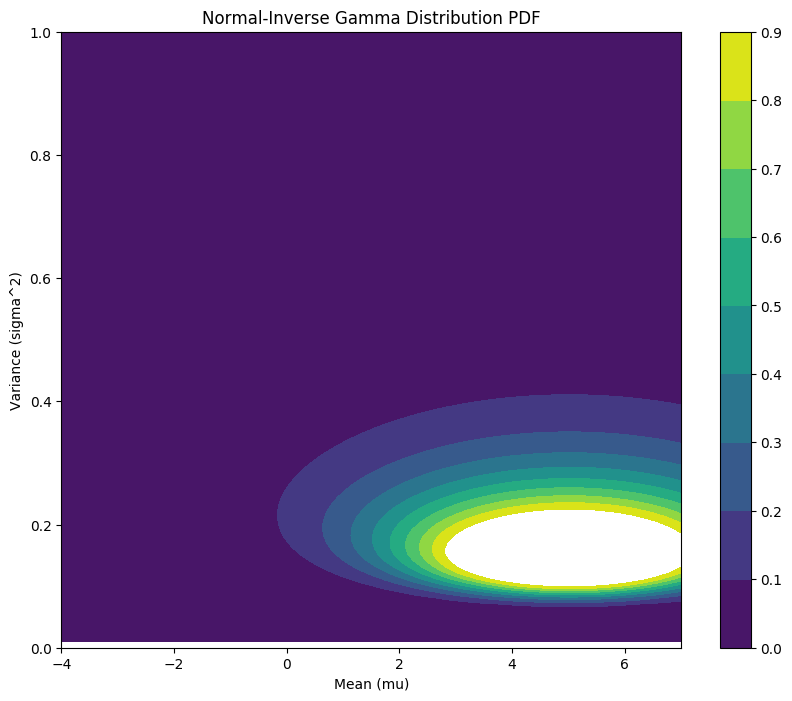

In [888]:
plt.figure(figsize=(10, 8))
cp = plt.contourf(mu, sigma2, pdf_values*1.5, levels=[x/10 for x in range(10)], cmap='viridis')
plt.colorbar(cp, boundaries=np.linspace(20,3,100))
plt.xlabel('Mean (mu)')
plt.ylabel('Variance (sigma^2)')
plt.title('Normal-Inverse Gamma Distribution PDF')

# 95% distributions

[-1.151356] [0.26724386] [3.001569] [0.05722879]
init:  [array([-1.151356], dtype=float32), array([0.10698829], dtype=float32)]
-1.1513559818267822 0.014133569400041523
mode_pdf:  [71.09662]


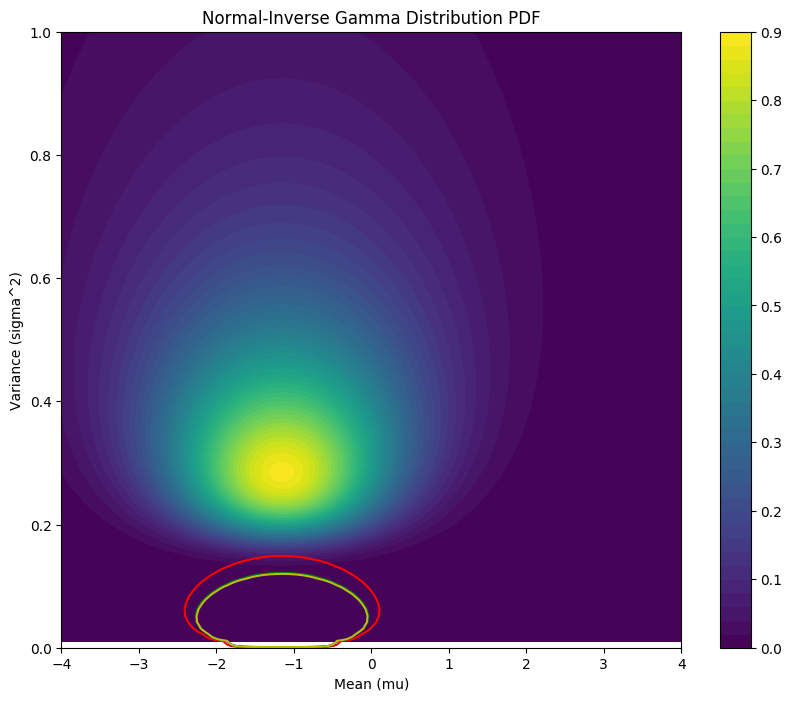

[3.0572953] [0.12840514] [3.9466772] [0.01647336]
init:  [array([3.0572953], dtype=float32), array([0.04353788], dtype=float32)]
3.057295322418213 0.0030219207228935206
mode_pdf:  [530.6377]


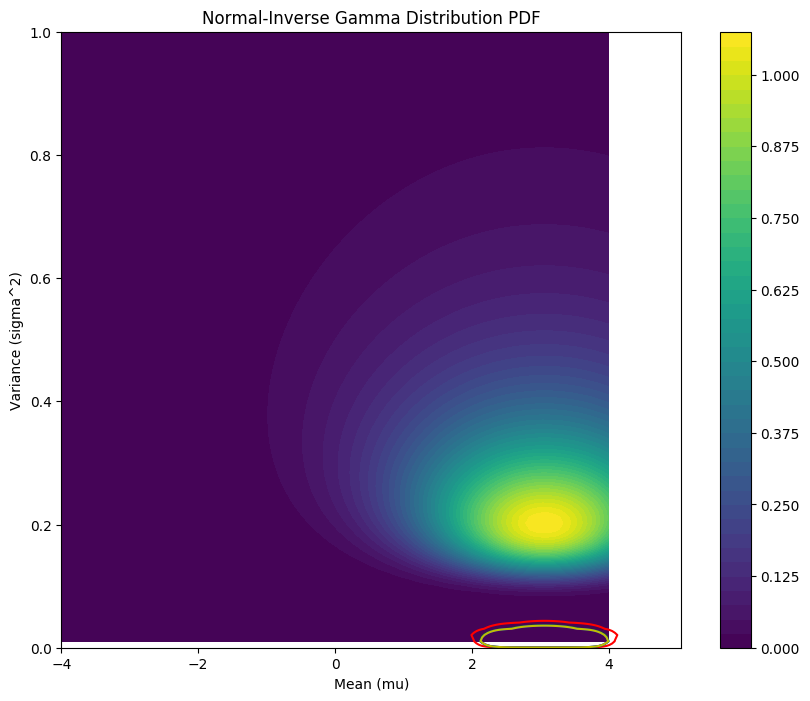

In [853]:
mu_range = (0, 4)
sigma2_range = (0, 0.3)

data = [-1., 3.]
for d in data:
    mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor([d]))]
    print(mu_0, lambda_, alpha, beta)
    # Define parameters for the Normal-Inverse Gamma distribution
    # mu_0 = 0  # Prior mean
    # lambda_ = 1  # Scale parameter
    # alpha = 2  # Shape parameter
    # beta = 2  # Scale parameter
    
    # Create a grid for mean (mu) and variance (sigma^2)
    mu = np.linspace(-4, 4, 100)
    sigma2 = np.linspace(0., 1., 100)
    mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)
    
    # Compute the probability density function values for the Normal-Inverse Gamma distribution
    pdf_values = np.zeros_like(mu_grid)
    
    for i in range(mu_grid.shape[0]):
        for j in range(mu_grid.shape[1]):
            mu_val = mu_grid[i, j]
            sigma2_val = sigma2_grid[i, j]
            # Normal-Inverse Gamma PDF (up to proportionality constant)
            # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
            #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
            pdf_values[i, j] = invgamma.pdf(sigma2_val, alpha, beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

    
    # Plot the PDF values
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(mu, sigma2, pdf_values, levels=50, cmap='viridis')
    plt.colorbar(cp)
    
    mu0, kappa, alpha, beta = mu_0, lambda_, alpha, beta
    c_list = ['r','g', 'b','y']
    sigma0 = beta / ((alpha-1) * kappa)
    mu_range = (mu0-2, mu0+2)
    sigma2_range = (sigma0/100, 1)
    initial_guess = [mu0,sigma0]#[3,0.12]
    print("init: ",initial_guess)
    result = minimize(neg_pdf, initial_guess, bounds=[mu_range, sigma2_range])
    mode_mu, mode_sigma2 = result.x
    print(mode_mu, mode_sigma2)
    # Find the contour level for 10% cumulative probability
    mode_pdf_ = normal_inverse_gamma_pdf(mode_mu, mode_sigma2, mu0, kappa, alpha, beta)
    print("mode_pdf: ",mode_pdf_)
    for idx, t in enumerate([1e-1, 1e-2, 1e-6, 1e-10]):
        # mode_pdf = normal_inverse_gamma_pdf(mode_mu, mode_sigma2, mu0, kappa, alpha, beta)
        threshold = t
        def cumulative_probability(mu, sigma2, mu0, kappa, alpha, beta, mode_pdf, threshold):
            def integrand(m, s2):
                return normal_inverse_gamma_pdf(m, s2, mu0, kappa, alpha, beta)
            
            def integrand_normalized(m, s2):
                return integrand(m, s2) / mode_pdf
            
            integral, error = dblquad(integrand_normalized, sigma2_range[0], sigma2, lambda _: mu_range[0], lambda _: mu)
            return integral - threshold
    
            
        def find_contour_level():
            def objective(c):
                return (cumulative_probability(mode_mu, mode_sigma2, mu0, kappa, alpha, beta, mode_pdf, c) - threshold)**2
            result = minimize(objective, mode_pdf_, bounds=[(0, mode_pdf_)])
            return result.x[0]
    
        contour_level = find_contour_level()
        # Generate the contour plot
        mu_vals = np.linspace(*mu_range, 100)
        sigma2_vals = np.linspace(*sigma2_range, 100)
        MU, SIGMA2 = np.meshgrid(mu_vals, sigma2_vals)
        pdf_vals = normal_inverse_gamma_pdf(MU, SIGMA2, mu0, kappa, alpha, beta)
        cp = plt.contour(MU, SIGMA2, pdf_vals, levels=[contour_level], colors=c_list[idx])
    
    plt.xlabel('Mean (mu)')
    plt.ylabel('Variance (sigma^2)')
    plt.title('Normal-Inverse Gamma Distribution PDF')
    plt.show()

In [474]:
test_mu = mu0

test_sigma2 = ((beta) / ((alpha-1) * lambda_))

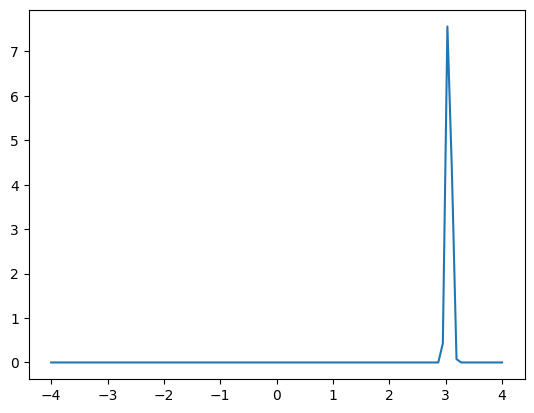

In [477]:
l = np.linspace(-4, 4, 100)
plt.plot(l, norm.pdf(l, test_mu, test_sigma2))
plt.show()

In [343]:
# Define the range for integration
mu_range = (0, 4)
sigma2_range = (0, 0.3)

# Normal-Inverse Gamma PDF
def normal_inverse_gamma_pdf(mu, sigma2, mu0, kappa, alpha, beta):
    coeff = np.sqrt(kappa / (2 * np.pi * sigma2))
    prior_mu = np.exp(-kappa * (mu - mu0) ** 2 / (2 * sigma2))
    prior_sigma2 = beta ** alpha / gamma(alpha) * (sigma2 ** (-alpha - 1)) * np.exp(-beta / sigma2)
    return coeff * prior_mu * prior_sigma2

# Find the mode (most probable point) of the NIG distribution
def neg_pdf(params):
    mu, sigma2 = params
    return -normal_inverse_gamma_pdf(mu, sigma2, mu0, kappa, alpha, beta)

# Define the cumulative probability function





0.04353787397636278
3.057291701704791 0.0030244760565801194
mode_pdf:  530.6389006669541
c:  [530.63890067]
c:  [530.63890066]
c:  [0.]
c:  [1.e-08]
c:  [0.04700812]
c:  [0.04700813]
      fun: array([8.23075192e-16])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.73785741e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([0.04700812])
out contour:  0.04700811565603916
c:  [530.63890067]
c:  [530.63890066]
c:  [0.]
c:  [1.e-08]
c:  [0.13700824]
c:  [0.13700825]
      fun: array([2.26477087e-14])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.10983114e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([0.13700824])
out contour:  0.13700823745830887
c:  [530.63890067]
c:  [530.63890066]
c:  [0.]
c:  [1.e-08]
c:  [0.14600817]
c:  

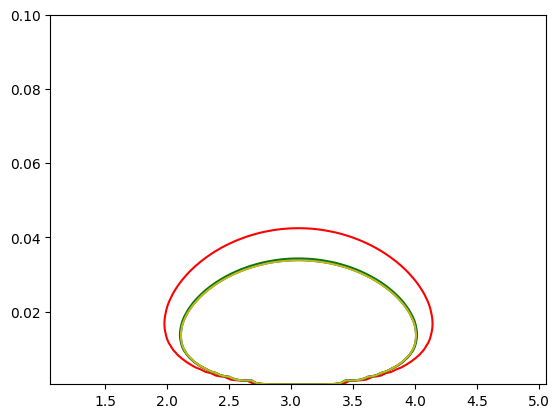

In [485]:
# Define the range for integration
# mu_range = (0, 4)
# sigma2_range = (0, 0.3)
# Define the range for integration

mu0, kappa, alpha, beta = 3.0572953, 0.12840514, 3.9466772, 0.01647336
c_list = ['r','g', 'b','y']
sigma0 = beta / ((alpha-1) * kappa)
print(sigma0)


mu_range = (mu0-2, mu0+2)
sigma2_range = (sigma0/100, 0.1)

initial_guess = [mu0,sigma0]#[3,0.12]
result = minimize(neg_pdf, initial_guess, bounds=[mu_range, sigma2_range])
mode_mu, mode_sigma2 = result.x
print(mode_mu, mode_sigma2)
# Find the contour level for 10% cumulative probability
mode_pdf_ = normal_inverse_gamma_pdf(mode_mu, mode_sigma2, mu0, kappa, alpha, beta)
print("mode_pdf: ",mode_pdf_)
for idx, t in enumerate([1e-1, 1e-2, 1e-3, 1e-4]):#1e-3, 1e-4, 1e-5, 1e-6]):
    # mode_pdf = normal_inverse_gamma_pdf(mode_mu, mode_sigma2, mu0, kappa, alpha, beta)
    threshold = t
    def cumulative_probability(mu, sigma2, mu0, kappa, alpha, beta, mode_pdf, threshold):
        def integrand(m, s2):
            return normal_inverse_gamma_pdf(m, s2, mu0, kappa, alpha, beta)
        
        def integrand_normalized(m, s2):
            return integrand(m, s2) / mode_pdf
        
        integral, error = dblquad(integrand_normalized, sigma2_range[0], sigma2, lambda _: mu_range[0], lambda _: mu)
        return integral - threshold

        
    def find_contour_level():
        def objective(c):
            print("c: ",c)
            return (cumulative_probability(mode_mu, mode_sigma2, mu0, kappa, alpha, beta, mode_pdf, c) - threshold)**2
        result = minimize(objective, mode_pdf_, bounds=[(0, mode_pdf_)], options={'maxiter': 3, 'disp': True})
        print(result)
        return result.x[0]

    contour_level = find_contour_level()
    print("out contour: ",contour_level)
    # Generate the contour plot
    mu_vals = np.linspace(*mu_range, 100)
    sigma2_vals = np.linspace(*sigma2_range, 100)
    MU, SIGMA2 = np.meshgrid(mu_vals, sigma2_vals)
    pdf_vals = normal_inverse_gamma_pdf(MU, SIGMA2, mu0, kappa, alpha, beta)
    cp = plt.contour(MU, SIGMA2, pdf_vals, levels=[contour_level], colors=c_list[idx])
plt.show()

In [253]:
from scipy.integrate import dblquad

0 1 3 2


/tmp/ipykernel_2666982/3736134585.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
/tmp/ipykernel_2666982/3736134585.py:34: RuntimeWarning: invalid value encountered in double_scalars
  pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \


0.027349944603022293


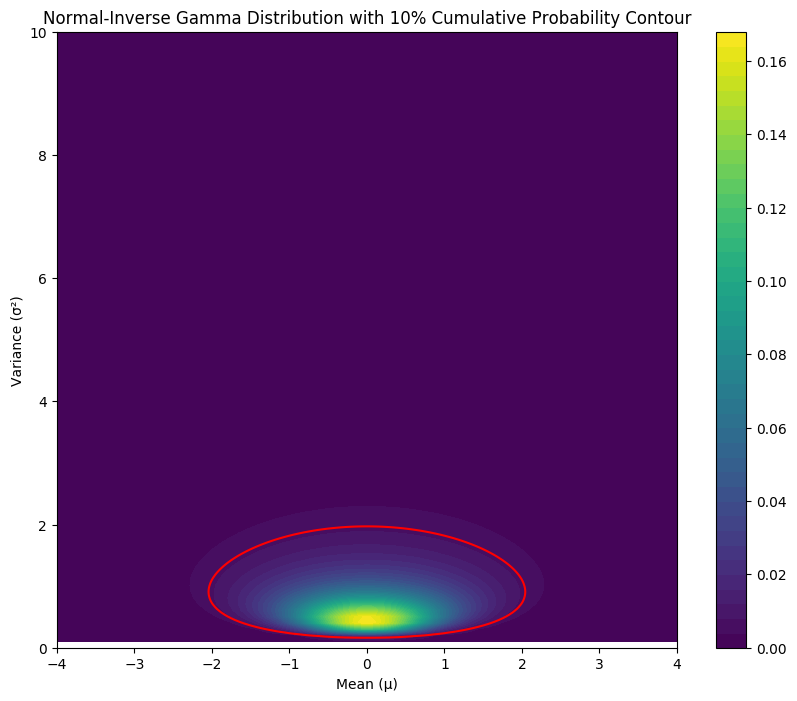

In [462]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.stats import norm, invgamma
from scipy.optimize import minimize

# Parameters for NIG distribution
mu0 = 0
kappa = 1
alpha = 3
beta = 2

mu_0, lambda_, alpha, beta = 0,1,3,2
print(mu_0, lambda_, alpha, beta)
# Define parameters for the Normal-Inverse Gamma distribution
# mu_0 = 0  # Prior mean
# lambda_ = 1  # Scale parameter
# alpha = 2  # Shape parameter
# beta = 2  # Scale parameter

# Create a grid for mean (mu) and variance (sigma^2)
mu = np.linspace(-4, 4, 100)
sigma2 = np.linspace(0., 10, 100)
mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)

# Compute the probability density function values for the Normal-Inverse Gamma distribution
pdf_values = np.zeros_like(mu_grid)

for i in range(mu_grid.shape[0]):
    for j in range(mu_grid.shape[1]):
        mu_val = mu_grid[i, j]
        sigma2_val = sigma2_grid[i, j]
        # Normal-Inverse Gamma PDF (up to proportionality constant)
        pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
                           norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

# Plot the PDF values
plt.figure(figsize=(10, 8))
cp = plt.contourf(mu, sigma2, pdf_values, levels=50, cmap='viridis')
plt.colorbar(cp)



# Normal-Inverse Gamma PDF
def normal_inverse_gamma_pdf(mu, sigma2, mu0, kappa, alpha, beta):
    coeff = np.sqrt(kappa / (2 * np.pi * sigma2))
    prior_mu = np.exp(-kappa * (mu - mu0) ** 2 / (2 * sigma2))
    prior_sigma2 = beta ** alpha / gamma(alpha) * (sigma2 ** (-alpha - 1)) * np.exp(-beta / sigma2)
    return coeff * prior_mu * prior_sigma2

# Define the range for integration
mu_range = (-10, 10)
sigma2_range = (0.01, 10)

# Find the mode (most probable point) of the NIG distribution
def neg_pdf(params):
    mu, sigma2 = params
    return -normal_inverse_gamma_pdf(mu, sigma2, mu0, kappa, alpha, beta)

initial_guess = [0, 1]
result = minimize(neg_pdf, initial_guess, bounds=[mu_range, sigma2_range])
mode_mu, mode_sigma2 = result.x

# Define the cumulative probability function
def cumulative_probability(mu, sigma2, mu0, kappa, alpha, beta, mode_pdf, threshold):
    def integrand(m, s2):
        return normal_inverse_gamma_pdf(m, s2, mu0, kappa, alpha, beta)
    
    def integrand_normalized(m, s2):
        return integrand(m, s2) / mode_pdf
    
    integral, error = dblquad(integrand_normalized, sigma2_range[0], sigma2, lambda _: mu_range[0], lambda _: mu)
    return integral - threshold

# Find the contour level for 10% cumulative probability
mode_pdf = normal_inverse_gamma_pdf(mode_mu, mode_sigma2, mu0, kappa, alpha, beta)
threshold = 0.1

def find_contour_level():
    
    def objective(c):
        return (cumulative_probability(mode_mu, mode_sigma2, mu0, kappa, alpha, beta, mode_pdf, c) - threshold)**2
    result = minimize(objective, mode_pdf, bounds=[(0, mode_pdf)])
    return result.x[0]

contour_level = find_contour_level()
print(contour_level)
# Generate the contour plot
mu_vals = np.linspace(-3, 3, 100)
sigma2_vals = np.linspace(0.1, 3, 100)
MU, SIGMA2 = np.meshgrid(mu_vals, sigma2_vals)
pdf_vals = normal_inverse_gamma_pdf(MU, SIGMA2, mu0, kappa, alpha, beta)

cp = plt.contour(MU, SIGMA2, pdf_vals, levels=[contour_level], colors='red')
plt.xlabel('Mean (μ)')
plt.ylabel('Variance (σ²)')
plt.title('Normal-Inverse Gamma Distribution with 10% Cumulative Probability Contour')
plt.show()
